In [1]:
# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
from scipy import stats
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
#subjects = ["id_100206"]
# or automatically detect all
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 309 (delta 60), reused 10 (delta 10), pack-reused 173 (from 1)
Receiving objects: 100% (309/309), 31.08 MiB | 25.83 MiB/s, done.
Resolving deltas: 100% (101/101), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


In [2]:
# ============================================
# 📦 Load EC_t and X for all subjects
# ============================================

ECts = {}   # will hold EC_t arrays per subject
Xs   = {}   # will hold input X arrays per subject

for sid in subjects:
    ECt_path = os.path.join(ects_dir, f"{sid}_ECt.npy")
    X_path   = os.path.join(preproc_dir, f"{sid}_inputs.npy")

    if not os.path.exists(ECt_path):
        print(f"⚠️ Skipping {sid}: EC_t file not found.")
        continue
    if not os.path.exists(X_path):
        print(f"⚠️ Skipping {sid}: inputs file not found.")
        continue

    ECts[sid] = np.load(ECt_path)
    Xs[sid]   = np.load(X_path)

    print(f"✅ Loaded {sid}: EC_t {ECts[sid].shape}, X {Xs[sid].shape}")

print(f"\n🎯 Loaded {len(ECts)} subjects successfully.")


✅ Loaded id_100206: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_100307: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_100408: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101006: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101107: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101309: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101915: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102008: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102109: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102311: EC_t (500, 450, 450), X (4677, 1350)

🎯 Loaded 10 subjects successfully.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

# =====================================================
# 🔹 Compute energy–effect correlation for all subjects
# =====================================================

results = []
scatter_data = {}  # optional: store per-subject arrays for later plotting
energy_global = []
energy_node = []
for sid in ECts.keys():
    EC_t = ECts[sid]
    X = Xs[sid]
    M, N = EC_t.shape[0], EC_t.shape[1]
    S = X.shape[1] // N

    # Energy of baseline state at time t
    x_t = X[:M, :]                      # last N entries = state at time t
    E_t = np.sum(x_t**2, axis=1)          # shape (M,)
    energy_global.append(E_t)
    e_t = x_t**2
    energy_node.append(e_t)
    # Mean L2 perturbation magnitude at time t
    EC_mean_t = np.mean(np.sum(EC_t**2, axis=2), axis=1)   # shape (M,)

    # Correlation
    r, p = pearsonr(E_t, EC_mean_t)
    results.append(dict(subj=sid, r=r, p=p))

    scatter_data[sid] = (E_t, EC_mean_t)
    print(f"{sid}: r = {r:.3f}, p = {p:.2g}")

# Convert results to DataFrame
df_corr = pd.DataFrame(results)
print("\nAverage correlation across subjects:", df_corr['r'].mean())

id_100206: r = -0.614, p = 4.5e-53
id_100307: r = -0.605, p = 3.7e-51
id_100408: r = -0.530, p = 1.2e-37
id_101006: r = -0.714, p = 2.8e-79
id_101107: r = -0.682, p = 1.3e-69
id_101309: r = -0.693, p = 9e-73
id_101915: r = -0.615, p = 2.8e-53
id_102008: r = -0.505, p = 8.7e-34
id_102109: r = -0.611, p = 1.7e-52
id_102311: r = -0.402, p = 7.5e-21

Average correlation across subjects: -0.5971304295833089


vs individual EC

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

# =====================================================
# 🔹 Compute energy–effect correlation per node
# =====================================================

subject_ids = list(ECts.keys())

all_r_nodes_local = []   # will become (n_subj, N_nodes)
all_p_nodes_local = []   # optional, (n_subj, N_nodes)
all_r_nodes_global = []   # will become (n_subj, N_nodes)
all_p_nodes_global = []   # optional, (n_subj, N_nodes)

for sid in subject_ids:
    EC_t = ECts[sid]
    X    = Xs[sid]

    M, N = EC_t.shape[0], EC_t.shape[1]   # M = time, N = nodes
    # assuming X has shape (M, N_nodes) or compatible with this slice
    x_t = X[:M, :]                        # shape (M, N_nodes)

    # per-node energy over time: energy of node j at time t
    e_t = x_t**2                          # shape (M, N_nodes)

    # Mean L2 perturbation magnitude at time t (same as before)
    EC_mean_t = np.mean(np.sum(EC_t**2, axis=2), axis=1)   # shape (M,)

    # Node-wise correlations for this subject
    r_nodes_local = np.zeros(N)
    p_nodes_local = np.zeros(N)
    r_nodes_global = np.zeros(N)
    p_nodes_global = np.zeros(N)

    for j in range(N):
        #r, p = pearsonr(e_t[:, j], EC_mean_t)
        r_local, p_local = pearsonr(e_t[:, j], np.sum(EC_t[:,j,:]**2,axis=1))
        r_global, p_global = pearsonr(np.sum(e_t[:, :], axis = 1), np.sum(EC_t[:,j,:]**2,axis=1))
        r_nodes_local[j] = r_local
        p_nodes_local[j] = p_local
        r_nodes_global[j] = r_global
        p_nodes_global[j] = p_global

    all_r_nodes_local.append(r_nodes_local)
    all_p_nodes_local.append(p_nodes_local)
    all_r_nodes_global.append(r_nodes_global)
    all_p_nodes_global.append(p_nodes_global)

all_r_nodes_local = np.vstack(all_r_nodes_local)  # shape: (n_subj, N_nodes)
all_p_nodes_local = np.vstack(all_p_nodes_local)  # optional
all_r_nodes_global = np.vstack(all_r_nodes_global)  # shape: (n_subj, N_nodes)
all_p_nodes_global = np.vstack(all_p_nodes_global)  # optional



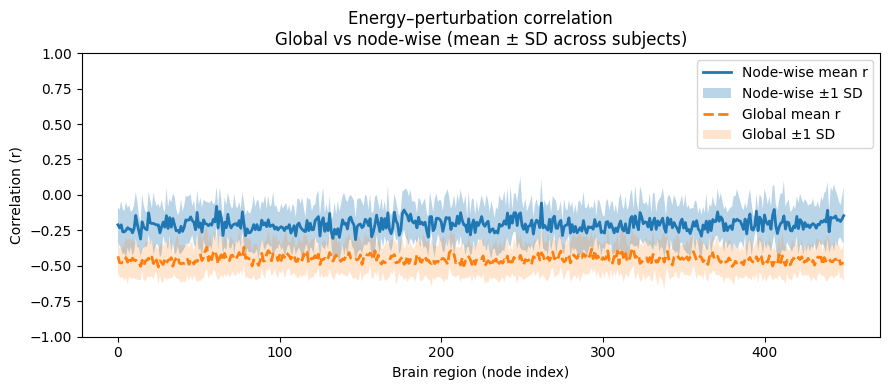

In [9]:
# ================================================
# Plot global vs regional in the SAME figure
# ================================================

mean_r_nodes = all_r_nodes_local.mean(axis=0)          # (N,)
std_r_nodes  = all_r_nodes_local.std(axis=0, ddof=1)

mean_r_global = all_r_nodes_global.mean(axis=0)
std_r_global  = all_r_nodes_global.std(axis=0, ddof=1)

nodes = np.arange(N)

plt.figure(figsize=(9, 4))

# Node-wise profile
plt.plot(nodes, mean_r_nodes, linewidth=2, label='Node-wise mean r')
plt.fill_between(nodes,
                 mean_r_nodes - std_r_nodes,
                 mean_r_nodes + std_r_nodes,
                 alpha=0.3,
                 label='Node-wise ±1 SD')

# Global profile
plt.plot(nodes,
         np.full_like(nodes, mean_r_global, dtype=float),
         linestyle='--',
         linewidth=2,
         label='Global mean r')
plt.fill_between(nodes,
                 mean_r_global - std_r_global,
                 mean_r_global + std_r_global,
                 alpha=0.2,
                 label='Global ±1 SD')

plt.xlabel('Brain region (node index)')
plt.ylabel('Correlation (r)')
plt.title('Energy–perturbation correlation\nGlobal vs node-wise (mean ± SD across subjects)')
plt.ylim(-1, 1)
plt.legend()
plt.tight_layout()
plt.show()


vs global EC

Node-wise r shape: (10, 450)
Mean global r: -0.588350791674952


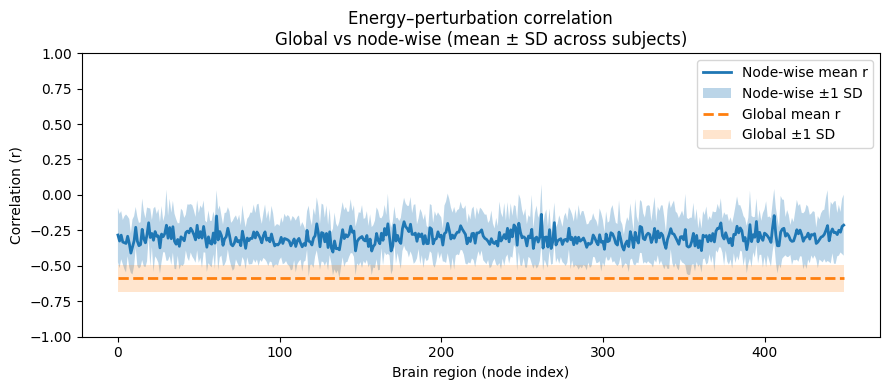

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

subject_ids = list(ECts.keys())

all_r_nodes = []     # shape -> (n_subj, N_nodes)
global_rs   = []     # shape -> (n_subj,)

for sid in subject_ids:
    EC_t = ECts[sid]      # shape (M, N, N)
    X    = Xs[sid]        # shape (M, >= N)

    M, N = EC_t.shape[0], EC_t.shape[1]   # time, nodes

    # --- state per node over time ---
    # If your nodes are the first N columns, change to: x_t = X[:M, :N]
    x_t = X[:M, -N:]                      # shape (M, N)

    # per-node energy over time
    e_t = x_t**2                          # shape (M, N)

    # global energy over time (sum over nodes)
    E_global_t = np.sum(e_t, axis=1)      # shape (M,)

    # mean L2 perturbation magnitude at time t (as before)
    EC_mean_t = np.mean(np.sum(EC_t**2, axis=2), axis=1)   # shape (M,)

    # ---- global correlation for this subject ----
    r_global, p_global = pearsonr(E_global_t, EC_mean_t)
    global_rs.append(r_global)

    # ---- node-wise correlations for this subject ----
    r_nodes = np.zeros(N)
    for j in range(N):
        r_j, _ = pearsonr(e_t[:, j], EC_mean_t)
        r_nodes[j] = r_j

    all_r_nodes.append(r_nodes)

# convert to arrays
all_r_nodes = np.vstack(all_r_nodes)   # (n_subj, N)
global_rs   = np.array(global_rs)      # (n_subj,)

# optional: store node-wise r in DataFrame
df_r_nodes = pd.DataFrame(
    all_r_nodes,
    index=subject_ids,
    columns=[f"node_{j}" for j in range(N)]
)

print("Node-wise r shape:", df_r_nodes.shape)
print("Mean global r:", global_rs.mean())

# ================================================
# Plot global vs regional in the SAME figure
# ================================================

mean_r_nodes = all_r_nodes.mean(axis=0)          # (N,)
std_r_nodes  = all_r_nodes.std(axis=0, ddof=1)

mean_r_global = global_rs.mean()
std_r_global  = global_rs.std(ddof=1)

nodes = np.arange(N)

plt.figure(figsize=(9, 4))

# Node-wise profile
plt.plot(nodes, mean_r_nodes, linewidth=2, label='Node-wise mean r')
plt.fill_between(nodes,
                 mean_r_nodes - std_r_nodes,
                 mean_r_nodes + std_r_nodes,
                 alpha=0.3,
                 label='Node-wise ±1 SD')

# Global (flat) profile
plt.plot(nodes,
         np.full_like(nodes, mean_r_global, dtype=float),
         linestyle='--',
         linewidth=2,
         label='Global mean r')
plt.fill_between(nodes,
                 mean_r_global - std_r_global,
                 mean_r_global + std_r_global,
                 alpha=0.2,
                 label='Global ±1 SD')

plt.xlabel('Brain region (node index)')
plt.ylabel('Correlation (r)')
plt.title('Energy–perturbation correlation\nGlobal vs node-wise (mean ± SD across subjects)')
plt.ylim(-1, 1)
plt.legend()
plt.tight_layout()
plt.show()


Phase instead of energy

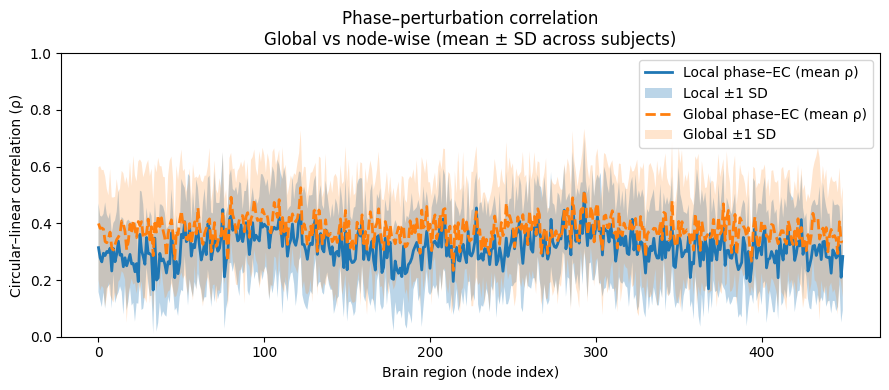

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, detrend
from scipy.stats import pearsonr, chi2

# =====================================================
# Helpers
# =====================================================

def hilbert_phase(x, do_detrend=True, zscore=False):
    """
    x: (T, N) real OR complex
    Returns:
      phi: (T, N) phase in radians
    """
    x = np.asarray(x)

    # If your state is already complex (e.g., Hopf), Hilbert is unnecessary:
    if np.iscomplexobj(x):
        return np.angle(x)

    # For real signals: (optional) remove drift / DC
    if do_detrend:
        x = detrend(x, axis=0, type="linear")

    # z-score doesn't really "fix" phase; scaling doesn't change phase,
    # but it's harmless after detrending if you want it.
    if zscore:
        x = (x - x.mean(axis=0, keepdims=True)) / (x.std(axis=0, ddof=1, keepdims=True) + 1e-12)

    analytic = hilbert(x, axis=0)
    return np.angle(analytic)


def circ_lin_corr(theta, x):
    """
    Circular-linear correlation between circular theta (radians) and linear x.
    Returns:
      rho in [0,1] and p-value (chi-square approx, df=2).
    """
    theta = np.asarray(theta).ravel()
    x = np.asarray(x).ravel()

    mask = np.isfinite(theta) & np.isfinite(x)
    theta = theta[mask]
    x = x[mask]

    n = len(x)
    if n < 5 or np.std(x) == 0:
        return np.nan, np.nan

    c = np.cos(theta)
    s = np.sin(theta)

    # If cos/sin are constant (pathological), avoid pearsonr crash
    if np.std(c) == 0 or np.std(s) == 0:
        return np.nan, np.nan

    r_xc, _ = pearsonr(x, c)
    r_xs, _ = pearsonr(x, s)
    r_cs, _ = pearsonr(c, s)

    denom = (1 - r_cs**2)
    if denom <= 0:
        return np.nan, np.nan

    rho2 = (r_xc**2 + r_xs**2 - 2 * r_xc * r_xs * r_cs) / denom
    rho2 = np.clip(rho2, 0, 1)
    rho = np.sqrt(rho2)

    # Large-sample test: n*rho^2 ~ chi^2_2
    p = 1 - chi2.cdf(n * rho2, df=2)
    return rho, p


# =====================================================
# 🔹 Compute phase–effect correlation per node
# =====================================================

# USER OPTIONS
DO_DETREND = True
DO_ZSCORE  = False  # scaling won't change phase; only keep if you want it for other reasons

subject_ids = list(ECts.keys())

all_r_nodes_local  = []
all_p_nodes_local  = []
all_r_nodes_global = []
all_p_nodes_global = []

for sid in subject_ids:
    EC_t = ECts[sid]      # expected shape: (M, N, N)
    X    = Xs[sid]        # expected shape: (>=M, N)

    M, N = EC_t.shape[0], EC_t.shape[1]
    x_t = X[:M, :]        # shape: (M, N)

    # --- Phase over time ---
    phi = hilbert_phase(x_t, do_detrend=DO_DETREND, zscore=DO_ZSCORE)  # (M, N)

    # Global phase (recommended): Kuramoto order parameter phase
    phi_global = np.angle(np.mean(np.exp(1j * phi), axis=1))           # (M,)

    r_nodes_local  = np.full(N, np.nan, dtype=float)
    p_nodes_local  = np.full(N, np.nan, dtype=float)
    r_nodes_global = np.full(N, np.nan, dtype=float)
    p_nodes_global = np.full(N, np.nan, dtype=float)

    for j in range(N):
        # EC magnitude for node j at time t (outgoing row energy)
        ec_j_t = np.sum(EC_t[:, j, :]**2, axis=1)  # (M,)

        # Local phase (node j) vs EC magnitude (node j)
        r_local, p_local = circ_lin_corr(phi[:, j], ec_j_t)

        # Global phase vs EC magnitude (node j)
        r_global, p_global = circ_lin_corr(phi_global, ec_j_t)

        r_nodes_local[j]  = r_local
        p_nodes_local[j]  = p_local
        r_nodes_global[j] = r_global
        p_nodes_global[j] = p_global

    all_r_nodes_local.append(r_nodes_local)
    all_p_nodes_local.append(p_nodes_local)
    all_r_nodes_global.append(r_nodes_global)
    all_p_nodes_global.append(p_nodes_global)

all_r_nodes_local  = np.vstack(all_r_nodes_local)   # (n_subj, N)
all_p_nodes_local  = np.vstack(all_p_nodes_local)
all_r_nodes_global = np.vstack(all_r_nodes_global)  # (n_subj, N)
all_p_nodes_global = np.vstack(all_p_nodes_global)

# =====================================================
# Plot local vs global (same figure)
# =====================================================

mean_r_local  = np.nanmean(all_r_nodes_local, axis=0)
std_r_local   = np.nanstd(all_r_nodes_local, axis=0, ddof=1)

mean_r_global = np.nanmean(all_r_nodes_global, axis=0)
std_r_global  = np.nanstd(all_r_nodes_global, axis=0, ddof=1)

nodes = np.arange(N)

plt.figure(figsize=(9, 4))

plt.plot(nodes, mean_r_local, linewidth=2, label='Local phase–EC (mean ρ)')
plt.fill_between(nodes,
                 mean_r_local - std_r_local,
                 mean_r_local + std_r_local,
                 alpha=0.3,
                 label='Local ±1 SD')

plt.plot(nodes, mean_r_global, linestyle='--', linewidth=2, label='Global phase–EC (mean ρ)')
plt.fill_between(nodes,
                 mean_r_global - std_r_global,
                 mean_r_global + std_r_global,
                 alpha=0.2,
                 label='Global ±1 SD')

plt.xlabel('Brain region (node index)')
plt.ylabel('Circular–linear correlation (ρ)')
plt.title('Phase–perturbation correlation\nGlobal vs node-wise (mean ± SD across subjects)')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


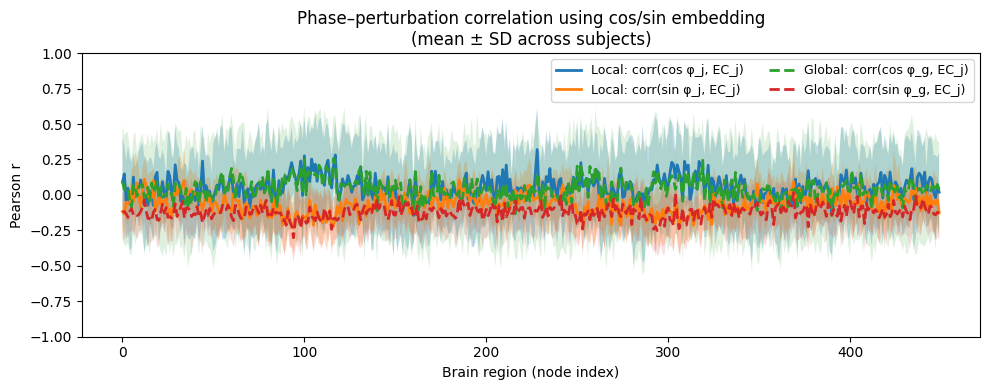

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, detrend
from scipy.stats import pearsonr

# =====================================================
# Phase extraction (no bandpass)
# =====================================================
def get_phase(x, do_detrend=True):
    """
    x: (T, N) real or complex
    returns phi: (T, N) in radians
    """
    x = np.asarray(x)

    # If already complex (e.g., Hopf state), take angle directly
    if np.iscomplexobj(x):
        return np.angle(x)

    # Real signal: detrend helps; scaling (zscore) doesn't change phase
    if do_detrend:
        x = detrend(x, axis=0, type="linear")

    analytic = hilbert(x, axis=0)
    return np.angle(analytic)


# =====================================================
# 🔹 Compute cos/sin(phase)–EC correlations per node
# =====================================================
subject_ids = list(ECts.keys())

all_r_cos_local   = []
all_p_cos_local   = []
all_r_sin_local   = []
all_p_sin_local   = []

all_r_cos_global  = []
all_p_cos_global  = []
all_r_sin_global  = []
all_p_sin_global  = []

for sid in subject_ids:
    EC_t = ECts[sid]   # expected (M, N, N)
    X    = Xs[sid]     # expected (>=M, N)

    M, N = EC_t.shape[0], EC_t.shape[1]
    x_t = X[:M, :]

    # Phase per node over time
    phi = get_phase(x_t, do_detrend=True)  # (M, N)

    # Global phase (Kuramoto order parameter phase)
    phi_global = np.angle(np.mean(np.exp(1j * phi), axis=1))  # (M,)

    cg = np.cos(phi_global)
    sg = np.sin(phi_global)

    r_cos_local  = np.full(N, np.nan)
    p_cos_local  = np.full(N, np.nan)
    r_sin_local  = np.full(N, np.nan)
    p_sin_local  = np.full(N, np.nan)

    r_cos_global = np.full(N, np.nan)
    p_cos_global = np.full(N, np.nan)
    r_sin_global = np.full(N, np.nan)
    p_sin_global = np.full(N, np.nan)

    for j in range(N):
        # EC magnitude for node j at each time t (outgoing row energy)
        y = np.sum(EC_t[:, j, :]**2, axis=1)  # (M,)

        c = np.cos(phi[:, j])
        s = np.sin(phi[:, j])

        # Local: correlate cos/sin(node phase) with EC magnitude of node j
        r_cos_local[j], p_cos_local[j] = pearsonr(c, y)
        r_sin_local[j], p_sin_local[j] = pearsonr(s, y)

        # Global: correlate cos/sin(global phase) with EC magnitude of node j
        r_cos_global[j], p_cos_global[j] = pearsonr(cg, y)
        r_sin_global[j], p_sin_global[j] = pearsonr(sg, y)

    all_r_cos_local.append(r_cos_local);   all_p_cos_local.append(p_cos_local)
    all_r_sin_local.append(r_sin_local);   all_p_sin_local.append(p_sin_local)
    all_r_cos_global.append(r_cos_global); all_p_cos_global.append(p_cos_global)
    all_r_sin_global.append(r_sin_global); all_p_sin_global.append(p_sin_global)

all_r_cos_local  = np.vstack(all_r_cos_local)
all_p_cos_local  = np.vstack(all_p_cos_local)
all_r_sin_local  = np.vstack(all_r_sin_local)
all_p_sin_local  = np.vstack(all_p_sin_local)

all_r_cos_global = np.vstack(all_r_cos_global)
all_p_cos_global = np.vstack(all_p_cos_global)
all_r_sin_global = np.vstack(all_r_sin_global)
all_p_sin_global = np.vstack(all_p_sin_global)

# =====================================================
# Plot mean ± SD across subjects (cos and sin; local and global)
# =====================================================
nodes = np.arange(N)

mean_cos_local = np.nanmean(all_r_cos_local, axis=0)
std_cos_local  = np.nanstd(all_r_cos_local, axis=0, ddof=1)

mean_sin_local = np.nanmean(all_r_sin_local, axis=0)
std_sin_local  = np.nanstd(all_r_sin_local, axis=0, ddof=1)

mean_cos_global = np.nanmean(all_r_cos_global, axis=0)
std_cos_global  = np.nanstd(all_r_cos_global, axis=0, ddof=1)

mean_sin_global = np.nanmean(all_r_sin_global, axis=0)
std_sin_global  = np.nanstd(all_r_sin_global, axis=0, ddof=1)

plt.figure(figsize=(10, 4))

# Local cos
plt.plot(nodes, mean_cos_local, linewidth=2, label='Local: corr(cos φ_j, EC_j)')
plt.fill_between(nodes, mean_cos_local-std_cos_local, mean_cos_local+std_cos_local, alpha=0.25)

# Local sin
plt.plot(nodes, mean_sin_local, linewidth=2, label='Local: corr(sin φ_j, EC_j)')
plt.fill_between(nodes, mean_sin_local-std_sin_local, mean_sin_local+std_sin_local, alpha=0.25)

# Global cos
plt.plot(nodes, mean_cos_global, linestyle='--', linewidth=2, label='Global: corr(cos φ_g, EC_j)')
plt.fill_between(nodes, mean_cos_global-std_cos_global, mean_cos_global+std_cos_global, alpha=0.15)

# Global sin
plt.plot(nodes, mean_sin_global, linestyle='--', linewidth=2, label='Global: corr(sin φ_g, EC_j)')
plt.fill_between(nodes, mean_sin_global-std_sin_global, mean_sin_global+std_sin_global, alpha=0.15)

plt.xlabel('Brain region (node index)')
plt.ylabel('Pearson r')
plt.title('Phase–perturbation correlation using cos/sin embedding\n(mean ± SD across subjects)')
plt.ylim(-1, 1)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()
